In [1]:
import copy
import glob
import os
import time
from collections import deque
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '..')

import gym
import gym_nav
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from a2c_ppo_acktr import algo, utils
from a2c_ppo_acktr.algo import gail
from a2c_ppo_acktr.arguments import get_args
from a2c_ppo_acktr.envs import make_vec_envs
from a2c_ppo_acktr.model import Policy
from a2c_ppo_acktr.storage import RolloutStorage
from evaluation import evaluate


In [2]:
env_name = 'Gridworld-v0'
log_dir = '/tmp/gym'
device = torch.device("cpu")
alg = 'ppo'
log_interval = 10

value_loss_coef = 0.5
entropy_coef = 0.01
gamma = 0.99
lr = 7e-4
eps = 1e-5
alpha = 0.99
max_grad_norm = 0.5

clip_param = 0.2
ppo_epoch = 4
num_mini_batch = 1

num_env_steps = 10000
num_steps = 5
num_processes = 1

use_gae = False
gae_lambda = 0.95
use_proper_time_limits = False

env = gym.make(env_name)
envs = make_vec_envs(env_name, 0, 1, gamma, log_dir, device, False, capture_video=1, 
                     env_kwargs={'reward_shaping': 2})

actor_critic = Policy(
    envs.observation_space.shape,
    envs.action_space,
    base_kwargs={'recurrent': True})
actor_critic.to(device)

if alg == 'a2c':
        agent = algo.A2C_ACKTR(
            actor_critic,
            value_loss_coef,
            entropy_coef,
            lr=lr,
            eps=eps,
            alpha=alpha,
            max_grad_norm=max_grad_norm)
elif alg == 'ppo':
    agent = algo.PPO(
        actor_critic,
        clip_param,
        ppo_epoch,
        num_mini_batch,
        value_loss_coef,
        entropy_coef,
        lr=lr,
        eps=eps,
        max_grad_norm=max_grad_norm)

global_step = 0

rollouts = RolloutStorage(num_steps, num_processes,
                          envs.observation_space.shape, envs.action_space,
                          actor_critic.recurrent_hidden_state_size)

obs = envs.reset()
rollouts.obs[0].copy_(obs)
rollouts.to(device)

episode_rewards = deque(maxlen=10)

start = time.time()
num_updates = int(
    num_env_steps) // num_steps // num_processes
for j in range(num_updates):

    for step in range(num_steps):
        #Andy: add global step
        global_step += 1 * num_processes
        # Sample actions
        with torch.no_grad():
            value, action, action_log_prob, recurrent_hidden_states = actor_critic.act(
                rollouts.obs[step], rollouts.recurrent_hidden_states[step],
                rollouts.masks[step])

        # Obser reward and next obs
        obs, reward, done, infos = envs.step(action)

        for info in infos:
            if 'episode' in info.keys():
                episode_rewards.append(info['episode']['r'])

        # If done then clean the history of observations.
        masks = torch.FloatTensor(
            [[0.0] if done_ else [1.0] for done_ in done])
        bad_masks = torch.FloatTensor(
            [[0.0] if 'bad_transition' in info.keys() else [1.0]
             for info in infos])
        rollouts.insert(obs, recurrent_hidden_states, action,
                        action_log_prob, value, reward, masks, bad_masks)

    with torch.no_grad():
        next_value = actor_critic.get_value(
            rollouts.obs[-1], rollouts.recurrent_hidden_states[-1],
            rollouts.masks[-1]).detach()
        
    rollouts.compute_returns(next_value, use_gae, gamma,
                             gae_lambda, use_proper_time_limits)

    if alg == 'ppo':
        value_loss, action_loss, dist_entropy, approx_kl, clipfracs = \
        agent.update(rollouts)

    else:
        value_loss, action_loss, dist_entropy = agent.update(rollouts)

    rollouts.after_update()

    if j % log_interval == 0 and len(episode_rewards) > 1:
        total_num_steps = (j + 1) * num_processes * num_steps
        end = time.time()
        print(
            "Updates {}, num timesteps {}, FPS {} \n Last {} training episodes: mean/median reward {:.1f}/{:.1f}, min/max reward {:.1f}/{:.1f}\n"
            .format(j, total_num_steps,
                    int(total_num_steps / (end - start)),
                    len(episode_rewards), np.mean(episode_rewards),
                    np.median(episode_rewards), np.min(episode_rewards),
                    np.max(episode_rewards), dist_entropy, value_loss,
                    action_loss))



C:\Users\Andy\miniconda3\lib\site-packages\gym\wrappers\record_video.py:42: UserWarning: WARN: Overwriting existing videos at C:\Users\Andy\Desktop\Work\github\training-rl-algo\video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  f"Overwriting existing videos at {self.video_folder} folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)"


Updates 80, num timesteps 405, FPS 70 
 Last 2 training episodes: mean/median reward 0.2/0.2, min/max reward 0.1/0.2

Updates 90, num timesteps 455, FPS 70 
 Last 2 training episodes: mean/median reward 0.2/0.2, min/max reward 0.1/0.2

Updates 100, num timesteps 505, FPS 66 
 Last 2 training episodes: mean/median reward 0.2/0.2, min/max reward 0.1/0.2

Updates 110, num timesteps 555, FPS 66 
 Last 2 training episodes: mean/median reward 0.2/0.2, min/max reward 0.1/0.2

Updates 120, num timesteps 605, FPS 65 
 Last 3 training episodes: mean/median reward 0.2/0.1, min/max reward 0.1/0.2

Updates 130, num timesteps 655, FPS 66 
 Last 3 training episodes: mean/median reward 0.2/0.1, min/max reward 0.1/0.2

Updates 140, num timesteps 705, FPS 64 
 Last 3 training episodes: mean/median reward 0.2/0.1, min/max reward 0.1/0.2

Updates 150, num timesteps 755, FPS 65 
 Last 3 training episodes: mean/median reward 0.2/0.1, min/max reward 0.1/0.2



KeyboardInterrupt: 

In [72]:
import numpy as np
import gym
from gym import spaces
import math
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import matplotlib.pyplot as plt
import io

MAX_MARCH = 20
EPSILON = 0.1
DEG_TO_RAD = 0.0174533
WINDOW_SIZE = (300, 300) # Width x Height in pixels
MAX_LEN = np.linalg.norm(WINDOW_SIZE)

object_to_idx = {
    'wall': 1,
    'goal': 2
}
color_to_idx = {
    'invisible': 0,
    'red': 1,
    'green': 2,
    'blue': 3,
    'yellow': 4,
    'purple': 5,
    'white': 6
}
# idx_to_rgb = {
#     1: np.array([230, 0, 0]),
#     2: np.array([0, 230, 0]),
#     3: np.array([0, 0, 230]),
#     4: np.array([230, 230, 0]),
#     5: np.array([230, 0, 230]),
#     6: np.array([230, 230, 230])
# }
idx_to_rgb = {
    1: np.array([0.9, 0, 0]),
    2: np.array([0, 0.9, 0]),
    3: np.array([0, 0, 0.9]),
    4: np.array([0.9, 0.9, 0]),
    5: np.array([0.9, 0, 0.9]),
    6: np.array([0.9, 0.9, 0.9])
}


    

    
def block_view_world(character, block_size=25, randomize_heading=0):
    '''
    Create a setting where the goal is perfectly blocked by a block
    randomize_heading:
        0 - always fixed
        1 - randomize headings but point agent in the right direction
        2 - randomize headings and point agent in random direction
    '''
#     print('call block view world')
    
    reset_objects()
    
    boxes, box_centers, box_sizes = generate_boxes(0)
    circles, circle_centers, circle_radii = generate_circles(0)
    
    #add a single block in the center of the screen
    add_box(Box(np.array([WINDOW_SIZE[0]/2, WINDOW_SIZE[1]/2]),
               np.array([block_size, block_size]), color=2))
    add_walls()
    
    base_size = 15
    base_x = 150
    base_y = 100
    base_radius = 88
    if randomize_heading > 0:
        angle = np.random.uniform(6.28)
        x = np.cos(angle) * base_radius
        y = np.sin(angle) * base_radius
        goal = Box(np.array([x + base_x, y + base_y]), np.array([base_size, base_size]), 
            is_goal=True, color=6)
        globals()['goal'] = goal
        add_box(goal)
        
        angle2 = angle + 3.14
        x = np.cos(angle2) * base_radius
        y = np.sin(angle2) * base_radius
        character.pos = np.array([x + base_x, y + base_y])
        
        if randomize_heading > 1:
            character.angle = np.random.uniform(6.28)
        else:
            character.angle = angle
            
        character.update_rays()
        
    else:
        #add the goal
        goal = Box(np.array([WINDOW_SIZE[0] - 50, WINDOW_SIZE[1]/2]),
                   np.array([base_size, base_size]),
                   is_goal=True, color=6)
        globals()['goal'] = goal
        add_box(goal)

        #set the agent position
        character.pos = np.array([50, WINDOW_SIZE[1]/2])
        character.angle = 0
        
        character.update_rays()



def dist(v):
    '''calculate length of vector'''
    return np.linalg.norm(v)



        
def randomize_location_and_angle(character, sep=True):
    '''
    create a random location and start direction for the character
    noting that we do not allow spawning into objects
    sep: if set to True, we will make sure character has a minimum distance away
        from the goal that is at least half the max distance possible from goal
        to end of window
    '''

    #max distance from goal to end of window
    max_goal_sep = dist(np.max([np.array(WINDOW_SIZE) - goal.center, goal.center], axis=0)) 
    sep = True
    searching = True
    while searching:
        pos = np.random.uniform(WINDOW_SIZE)
        goal_sep = dist(globals()['goal'].center - pos)

        if scene_sdf(pos)[0] > 0 and (not sep or goal_sep > max_goal_sep / 2):
            #position is okay
            searching = False
            
    character.pos = pos
    character.angle = np.random.uniform(6.28)
#     character.pos = np.array([100, 100])
#     character.angle = 0

    character.update_rays()




















class Character:
    def __init__(self, pos=[WINDOW_SIZE[0]/2, WINDOW_SIZE[1]/2], angle=0, color=4, size=10,
                fov=120*DEG_TO_RAD, num_rays=30, render_rays=True):
        '''
        Generate a character that can move through the window
        pos: starting position
        angle: starting angle (radians) angle always takes on values from -pi to pi
        color: color
        size: size
        fov: range of angles character can see using rays
        num_rays: fidelity of depth perception
        draw_rays: whether or not to draw the characters rays
        '''
        self.pos = pos
        self.angle = (angle + np.pi) % (2*np.pi) - np.pi
        self.color = color
        self.size = size
        self.fov = fov
        self.ray_splits = fov / num_rays
        self.render_rays = render_rays
        self.num_rays = num_rays
        
        self.rays = []
        
        fov_start = self.angle - self.fov/2
        for i in range(num_rays):
            self.rays.append(Ray(self.pos, fov_start + i*self.ray_splits))
    
    
    def update_rays(self, vis_walls=[], vis_wall_refs=[]):
        '''
        update the angle of the rays using own position and angle
        '''
        fov_start = self.angle - self.fov/2
        for i in range(self.num_rays):
            self.rays[i].update(start=self.pos, angle=fov_start + i*self.ray_splits, vis_walls=vis_walls, vis_wall_refs=vis_wall_refs)
            
            
    def draw_rays(self):
        '''
        draw the rays coming from character
        '''
        for ray in self.rays:
            ray.draw()
        
    
    def draw(self):
        '''
        draw the character
        '''
        angle1 = self.angle - 0.3
        angle2 = self.angle + 0.3
        point1 = [self.pos[0], self.pos[1]]
        point2 = [self.pos[0] - math.cos(angle1)*self.size, self.pos[1] - math.sin(angle1)*self.size]
        point3 = [self.pos[0] - math.cos(angle2)*self.size, self.pos[1] - math.sin(angle2)*self.size]

        draw_color = idx_to_rgb[self.color]
        
        poly = plt.Polygon([point1, point2, point3], fc=draw_color)
        plt.gca().add_patch(poly)

        
        if self.render_rays:
            self.draw_rays()
        
        
    def move(self, speed, col_walls, col_wall_refs, vis_walls, vis_wall_refs):
        '''
        move in the faced direction with number of pixels of speed
        collision detection uses the same ray marching algorithm
        after moving, update the rays
        
        Note we have to pass the walls that can be collided with for movement
        '''
        start = self.pos
        end = [self.pos[0] + math.cos(self.angle) * speed, self.pos[1] + math.sin(self.angle) * speed]
        
        min_dist, collision_obj = self.march(start, end, col_walls, col_wall_refs)

        if collision_obj == None:
            self.pos[0] += math.cos(self.angle) * speed
            self.pos[1] += math.sin(self.angle) * speed
            
        else:
            self.pos[0] += math.cos(self.angle) * (min_dist - speed * 0.1)
            self.pos[1] += math.sin(self.angle) * (min_dist - speed * 0.1)
        self.update_rays(vis_walls, vis_wall_refs)

        return collision_obj
            
            
    def march(self, start, end, col_walls, col_wall_refs):
        '''
        perform ray march, find collision with col_walls
        '''
        intersects = []
        for col_wall in col_walls:
            intersects.append(intersect(start, end, col_wall[0], col_wall[1]))
        min_dist = np.inf
        min_idx = None
        for idx, inter in enumerate(intersects):
            if inter != None:
                d = dist((inter[0]-start[0], inter[1]-start[1]))
                if d < min_dist:
                    min_dist = d
                    min_idx = idx
        
        if min_idx == None:
            return min_dist, min_idx
        else:
            return min_dist, col_wall_refs[min_idx]
    
        
    def rotate(self, angle, vis_walls, vis_wall_refs):
        self.angle += angle
        self.angle = (self.angle + np.pi) % (2*np.pi) - np.pi
        self.update_rays(vis_walls=vis_walls, vis_wall_refs=vis_wall_refs)
        
    
    def ray_obs(self, max_depth=MAX_LEN):
        '''
        Get all rays and their distances to objects
        normalize_depth: divide depth readings by value 
        '''
        ray_colors = []
        ray_depths = []
        for ray in self.rays:
            ray_colors.append(ray.touched_obj.color)
            ray_depths.append(ray.obj_dist)

        ray_colors = np.array(ray_colors) / 6
        ray_depths = np.array(ray_depths) / max_depth
        visual = np.append(ray_colors, ray_depths)
        return visual







class Box():
    def __init__(self, corner, size, color=1, is_goal=False):
        self.size = size #this is a size 2 array for length and height
        self.color = color
        self.is_goal = is_goal
        self.corner = corner
        self.center = [self.corner[0] + self.size[0]/2, self.corner[1] + self.size[1]/2]
        
            
    def draw(self, ax=None):
        rect = plt.Rectangle(self.corner, self.size[0], self.size[1], fc=idx_to_rgb[self.color])

        draw_color = idx_to_rgb[self.color]
        
        if ax == None:
            plt.gca().add_patch(rect)
        else:
            ax.add_patch(rect)
        
    def get_walls(self):
        walls = [
                 [(self.corner[0], self.corner[1]), (self.corner[0], self.corner[1]+self.size[1])], #bl to ul
                 [(self.corner[0], self.corner[1]), (self.corner[0]+self.size[0], self.corner[1])], #bl to br
                 [(self.corner[0], self.corner[1]+self.size[1]), (self.corner[0]+self.size[0], self.corner[1]+self.size[1])], #ul to ur
                 [(self.corner[0]+self.size[0], self.corner[1]), (self.corner[0]+self.size[0], self.corner[1]+self.size[1])], #br to ur
                ]
        return walls






class Ray():
    def __init__(self, start, angle, color=6):
        '''
        Ray for ray marching
        if render_march is True, then we render the sdf circles used to calculate march 
        '''
        self.start = start
        self.angle = angle
        self.color = color
        self.touched_obj = None
        self.obj_dist = MAX_LEN
        
        
    def update(self, start=None, angle=None, vis_walls=[], vis_wall_refs=[]):
        '''
        update position and angle, perform march, determine object and distance
        '''
        if start is not None:
            self.start = start
        if angle is not None:
            self.angle = angle
        self.obj_dist, self.touched_obj = self.march(vis_walls, vis_wall_refs)
        
                
    def march(self, vis_walls, vis_wall_refs):
        '''
        perform ray march, find collision with object
        '''
        end = self.start + np.array([np.cos(self.angle), np.sin(self.angle)]) * MAX_LEN
        # print(end)
        intersects = []
        for vis_wall in vis_walls:
            intersects.append(intersect(self.start, end, vis_wall[0], vis_wall[1]))
        
        min_dist = np.inf
        min_idx = 0
        for idx, inter in enumerate(intersects):
            if inter != None:
                d = dist((inter[0]-self.start[0], inter[1]-self.start[1]))
                if d < min_dist:
                    min_dist = d
                    min_idx = idx
        # print(min_dist)
        if min_idx == None:
            return min_dist, min_idx
        else:
            return min_dist, vis_wall_refs[min_idx]
    
    def draw(self):
        rect = plt.Rectangle(self.start, self.obj_dist, 1, self.angle * 180 / np.pi, fc=idx_to_rgb[self.color])

        draw_color = idx_to_rgb[self.color]
        plt.gca().add_patch(rect)
        # plt.scatter([self.start[0]+self.obj_dist*math.cos(self.angle)], [self.start[1]+self.obj_dist*math.sin(self.angle)])
        
            
            
            

def intersect(p1, p2, p3, p4):
    x1,y1 = p1
    x2,y2 = p2
    x3,y3 = p3
    x4,y4 = p4
    denom = (y4-y3)*(x2-x1) - (x4-x3)*(y2-y1)
    if denom == 0: # parallel
        return None
    ua = ((x4-x3)*(y1-y3) - (y4-y3)*(x1-x3)) / denom
    if ua < 0 or ua > 1: # out of range
        return None
    ub = ((x2-x1)*(y1-y3) - (y2-y1)*(x1-x3)) / denom
    if ub < 0 or ub > 1: # out of range
        return None
    x = x1 + ua * (x2-x1)
    y = y1 + ua * (y2-y1)
    return (x,y)






class NavEnvFlat(gym.Env):
    metadata = {"render.modes": ['rgb_array', 'human'], 'video.frames_per_second': 24}
    def __init__(self, num_rays=30, max_steps=200, num_objects=5,
                rew_structure='dist', give_heading=0, verbose=0,
                world_gen_func=None, world_gen_params={}, give_dist=True,
                give_time=False, collission_penalty=0, default_reward=0,
                sub_goal_reward=0.01, goal_visible=True):
        '''
        rew_structure: 'dist' - reward given based on distance to goal
                        'goal' - reward only given when goal reached
        give_heading: whether to additionally give a distance and direction to goal
        flat: whether to give observations in a flattened state
        world_gen_func: a function can be passed to manually create a world
            using some other rules. Note that it needs to generate objects, a goal, and
            set the agent position and heading
            The character will be passed as the argument
        '''
        super(NavEnvFlat, self).__init__()

        self.total_rewards = 0
        self.give_dist = give_dist
        self.give_heading = give_heading
        self.give_time = give_time
        self.collission_penalty = collission_penalty
        self.default_reward = default_reward
        self.sub_goal_reward = sub_goal_reward
        self.rew_structure = rew_structure
        self.verbose = verbose
        self.world_gen_func = world_gen_func
        self.world_gen_params = world_gen_params
        self.goal_visible = goal_visible

        observation_width = num_rays
        if give_dist:
            observation_width = observation_width * 2
        if give_heading:
            observation_width += 1
        if give_time:
            observation_width += 1

        self.observation_space = spaces.Box(low=0, high=6, shape=(observation_width,))
        self.action_space = spaces.Discrete(4) #turn left, forward, right as actions
        
        self.max_steps = max_steps
        self.current_steps = 0
        
        self.character = Character()
        self.num_objects = num_objects
        
        self.fig = None
        
        self.vis_walls = []
        self.vis_wall_refs = []
        self.col_walls = []
        self.col_wall_refs = []


        if self.world_gen_func is None:
            self.generate_world()
        else:
            self.world_gen_func(self.character, **self.world_gen_params)
        
        
    def step(self, action):
        reward = self.default_reward
        collision_obj = None
        done = False
        info = {}
        
        if action == 0:
            self.character.rotate(-0.2, self.vis_walls, self.vis_wall_refs)
        if action == 1:
            collision_obj = self.character.move(10, self.col_walls, self.col_wall_refs,
                                self.vis_walls, self.vis_wall_refs)
        if action == 2:
            self.character.rotate(0.2, self.vis_walls, self.vis_wall_refs)
        if action == 3:
            pass

        if self.rew_structure == 'dist':
            goal = self.boxes[-1]
            dist_to_goal = self.sub_goal_reward * \
                (MAX_LEN-dist(goal.center - self.character.pos)) / MAX_LEN
            reward = float(dist_to_goal)

            
        if collision_obj != None:
            if collision_obj.is_goal:
                if self.verbose:
                    print('goal reached!')
                reward = float(1)
                done = True
            else:
#                 reward = -10
                reward = float(self.collission_penalty)
        
        
        observation = self.get_observation()
        
        if self.current_steps > self.max_steps:
            done = True
        
        self.current_steps += 1
        self.total_rewards += reward
        if done and self.verbose:
            print('done, total_reward:{}'.format(self.total_rewards))
        return observation, reward, done, info
    

    def reset(self):
        if self.world_gen_func is None:
            self.generate_world()
        else:
            self.world_gen_func(self.character, **self.world_gen_params)
        
        self.character.update_rays(self.vis_walls, self.vis_wall_refs)
        observation = self.get_observation()
        self.current_steps = 0
        self.total_rewards = 0
        return observation

    
    def render(self, mode='rgb_array'):
        plt.style.use('dark_background')
        fig = plt.figure(figsize=(6,6))
        plt.xlim([0, WINDOW_SIZE[0]])
        plt.ylim([0, WINDOW_SIZE[1]])

        self.character.draw()
        for box in self.boxes:
            box.draw()

        fig.canvas.draw()
        image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        #trim borders
        image_from_plot = image_from_plot[52:380,52:390,:]
        
        # with io.BytesIO() as buff:
        #     fig.savefig(buff, format='raw')
        #     buff.seek(0)
        #     data = np.frombuffer(buff.getvalue(), dtype=np.uint8)
        # w, h = fig.canvas.get_width_height()
        # im = data.reshape((int(h), int(w), -1))
        
        if mode == 'human':
            plt.show()
            
        if mode == 'rgb_array':
            plt.close()
            return image_from_plot
            
            # return im
            
        
    def get_observation(self):
#         ray_depths, ray_colors = self.character.ray_obs()
#         return np.append(ray_depths, ray_colors)

        if self.give_heading > 0:
            raise NotImplementedError('Have not adjusted give_heading code')
            #tell where the goal is distance and heading
            ray_obs = self.character.ray_obs()
            goal = objects[-1]
            dist_to_goal = np.clip(dist(goal.center - self.character.pos), 0, 1000) / 1000
            heading = goal.center - self.character.pos
            heading = np.arctan2(heading[1], heading[0])

            if self.give_heading == 1:
                #only give distance to goal
                obs = np.vstack([ray_obs, [dist_to_goal, 0, 0]])
            elif self.give_heading == 2:
                #give distance and angle to goal
                obs = np.vstack([ray_obs, [dist_to_goal, heading/3.14, 0]])
            elif self.give_heading == 3:
                #give distance and angle to goal and current agent angle
                obs = np.vstack([ray_obs, [dist_to_goal, heading/3.14, self.character.angle]])
            
                        
            return np.array(obs.reshape(-1), dtype='float')
            
        else:
            obs = self.character.ray_obs()
            if not self.give_dist:
                obs = obs[:self.num_rays]

            return np.array(self.character.ray_obs().reshape(-1), dtype='float')
        

    def generate_world(self):
        self.boxes, walls, wall_refs = self.make_walls()

        #generate a goal
        corner = np.random.uniform(low=30, high=270, size=(2,))
        goal = Box(corner, [20, 20], color=6, is_goal=True)
        goal_walls, goal_wall_refs = self.get_walls([goal])
        if self.goal_visible:
            self.vis_walls, self.vis_wall_refs = walls + goal_walls, wall_refs + goal_wall_refs
            self.col_walls, self.col_wall_refs = walls + goal_walls, wall_refs + goal_wall_refs
        else:
            self.vis_walls, self.vis_wall_refs = walls, wall_refs
            self.col_walls, self.col_wall_refs = walls + goal_walls, wall_refs + goal_wall_refs
        self.boxes.append(goal)

        #generate character which must be at least some distance from the goal
        searching = True
        while searching:
            pos = np.random.uniform(low=30, high=270, size=(2,))
            if dist(corner - pos) > 50:
                searching = False
        angle = np.random.uniform(0, 2*np.pi)
        self.character = Character(pos, angle)



    def make_walls(self, thickness=1):
        boxes = []
        y = WINDOW_SIZE[1]
        x = WINDOW_SIZE[0]
        thickness = 5
        boxes.append(Box(np.array([0, 0]), np.array([thickness, y]), color=1))
        boxes.append(Box(np.array([0, 0]), np.array([x, thickness]), color=1))
        boxes.append(Box(np.array([0, y-thickness]), np.array([x, thickness]), color=1))
        boxes.append(Box(np.array([x-thickness, 0]), np.array([thickness, y]), color=1))
        
        # manually create walls here so that we don't need to check more walls than necessary
        # on intersections
        walls = [
            [[thickness, 0], [thickness, y]],
            [[0, thickness], [x, thickness]],
            [[0, y-thickness], [x, y-thickness]],
            [[x-thickness, 0], [x-thickness, y]]
        ]
        wall_refs = [
            boxes[0],
            boxes[1],
            boxes[2],
            boxes[3]
        ]
        
        return boxes, walls, wall_refs
        
    def get_walls(self, boxes):
        '''
        Get tuples of points to intersect with for rays from a list of boxes
        '''
        walls = []
        wall_refs = []
        for box in boxes:
            walls = walls + box.get_walls()
            wall_refs = wall_refs + [box] * 4
        return walls, wall_refs

    

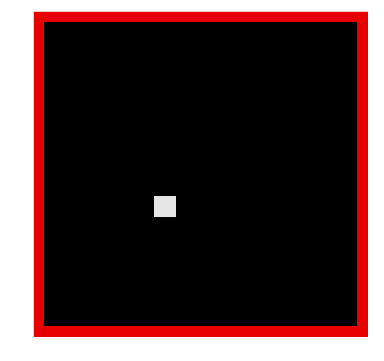

In [68]:
fig, ax = plt.subplots(1,1,figsize=(6,6), frameon=False)
canvas = FigureCanvas(fig)
# ax.axis('off')
# plt.axis('off')
# ax.get_xaxis().set_visible('False')
# ax.get_yaxis().set_visible('False')
# ax.margins(0)
ax.set_xlim([0, 300])
ax.set_ylim([0, 300])

for box in env.boxes:
    box.draw(ax)

fig.canvas.draw()
image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
# canvas.draw()
# image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape(canvas.get_width_height()[::-1]+(3,))
# plt.close()

In [104]:
env = NavEnvFlat()

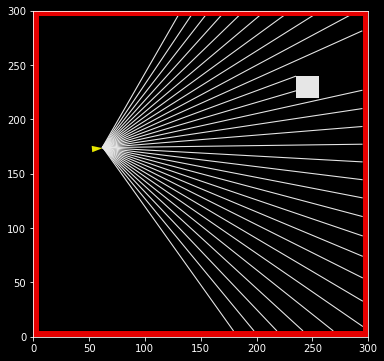

In [105]:
env.reset()
env.render('human')

In [130]:
env.step(1)

(array([0.16666667, 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        0.13296614, 0.01969852, 0.01191168, 0.00856691, 0.00671427,
        0.00554265, 0.00473882, 0.0041563 , 0.00371744, 0.0033773 ,
        0.00310805, 0.00289161, 0.00271572, 0.00257182, 0.00245375,
        0.00235702, 0.00227831, 0.00221513, 0.00216563, 0.00212843,
        0.00210256, 0.00208736, 0.00208245, 0.00208771, 0.00210327,
        0.00212951, 0.00216711, 0.00221706, 0.00228074, 0.00236002]),
 1.0,
 True,
 {})

# Writing code to read tensorboard logs

In [75]:
#!/usr/bin/env python3

import glob
import os
import pprint
import traceback

import click
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator


# Extraction function
def tflog2pandas(path: str) -> pd.DataFrame:
    """convert single tensorflow log file to pandas DataFrame
    Parameters
    ----------
    path : str
        path to tensorflow log file
    Returns
    -------
    pd.DataFrame
        converted dataframe
    """
    DEFAULT_SIZE_GUIDANCE = {
        "compressedHistograms": 1,
        "images": 1,
        "scalars": 0,  # 0 means load all
        "histograms": 1,
    }
    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": []})
    try:
        event_acc = EventAccumulator(path, DEFAULT_SIZE_GUIDANCE)
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "step": step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    return runlog_data

In [77]:
tests = os.listdir('../runs')
dir1 = tests[0]
fname = os.listdir('../runs/' + dir1)[0]
path = '../runs/' + dir1 + '/' + fname

In [97]:
df = tflog2pandas(path)

In [98]:
df.to_csv('../runs/' + dir1 + '/' + 'test.csv')

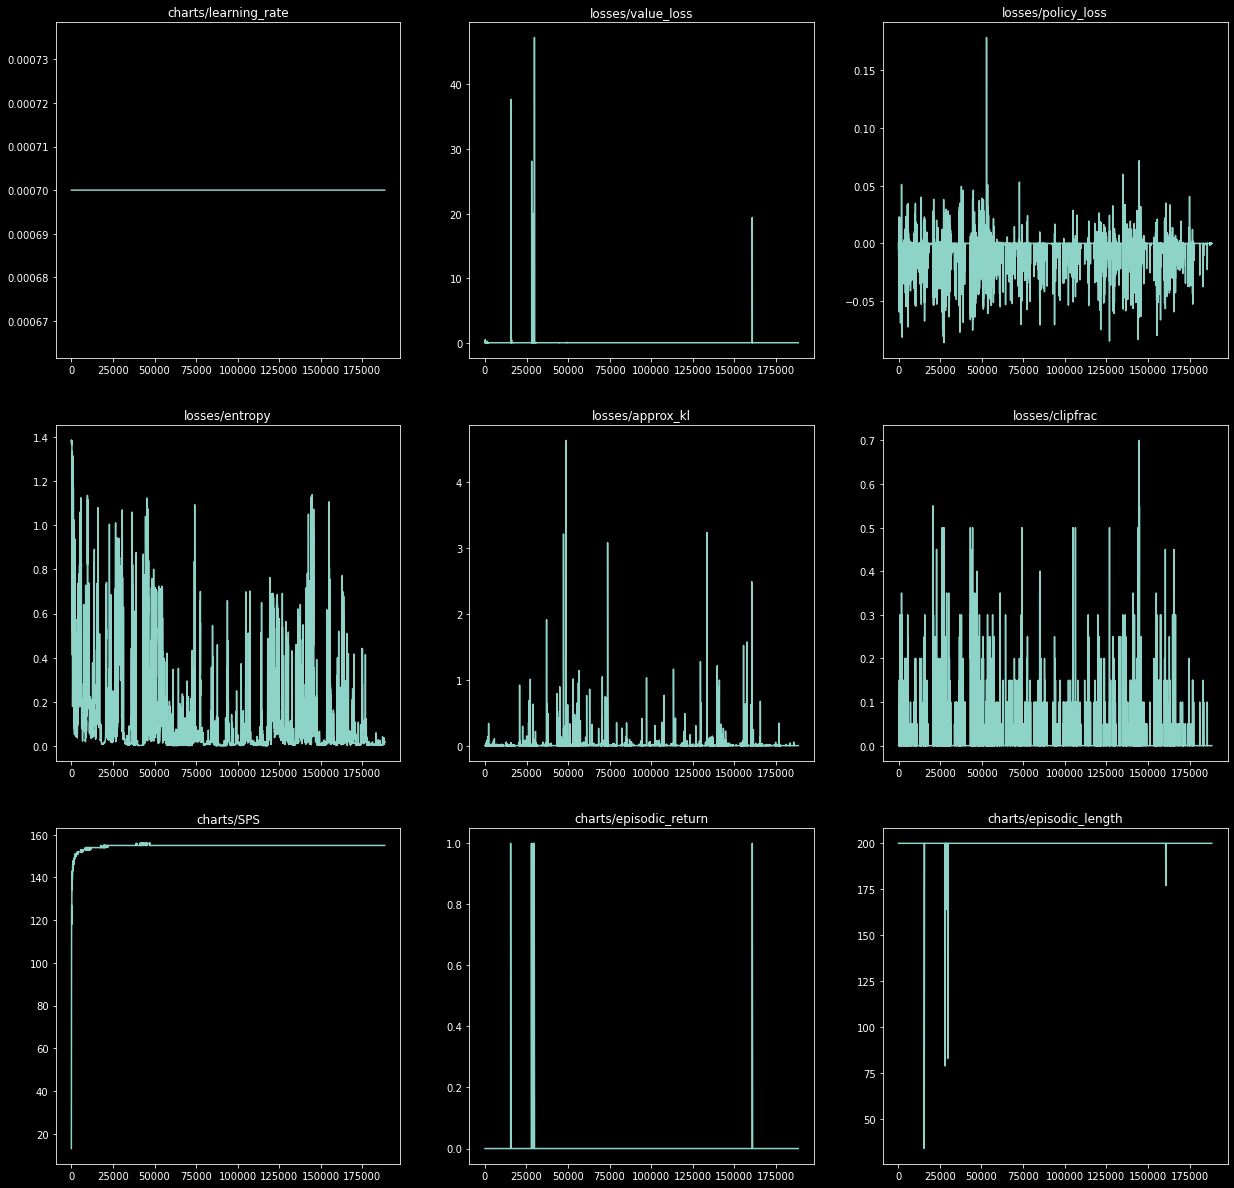

In [102]:
fig, ax = plt.subplots(3, 3, figsize=(21, 21))

for i, chart in enumerate(df['metric'].unique()):
    # print(chart)
    x = i // 3
    y = i % 3
    
    d = df[df['metric'] == chart]
    ax[x, y].plot(d['step'], d['value'])
    ax[x, y].set_title(chart)
    

In [103]:
d

,metric,value,step
0,charts/episodic_length,200.0,200.0
1,charts/episodic_length,200.0,400.0
2,charts/episodic_length,200.0,600.0
3,charts/episodic_length,200.0,800.0
4,charts/episodic_length,200.0,1000.0
...,...,...,...
939,charts/episodic_length,200.0,187537.0
940,charts/episodic_length,200.0,187737.0
941,charts/episodic_length,200.0,187937.0
942,charts/episodic_length,200.0,188137.0


In [96]:
df['metric'].unique()

array(['charts/learning_rate'], dtype=object)

In [94]:
i

0

In [92]:
df.columns

Index(['metric', 'value', 'step'], dtype='object')

In [82]:
df


,metric,value,step
0,charts/learning_rate,0.0007,5.0
1,charts/learning_rate,0.0007,10.0
2,charts/learning_rate,0.0007,15.0
3,charts/learning_rate,0.0007,20.0
4,charts/learning_rate,0.0007,25.0
...,...,...,...
939,charts/episodic_length,200.0000,187537.0
940,charts/episodic_length,200.0000,187737.0
941,charts/episodic_length,200.0000,187937.0
942,charts/episodic_length,200.0000,188137.0
